In [1]:
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp, Statevector

# optimizer imports
from qiskit_algorithms.optimizers import *

# Plotting functions
import matplotlib.pyplot as plt

from functools import partial

# Global dictionary
cost_history_dict = {
	"prev_vector": None,
	"iters": 0,
	"cost_history": [],
}

from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
from qiskit_aer import AerSimulator
backend = AerSimulator()

## Hamiltonian

Our next two components: the PQC and measurement strategy, may depend quite a bit on our Hamiltonian, and any constraints which we wish to satisfy (however for the sake of simplicity we will suppose that we have no extra constraints). However, for now we shall take statevector simulations, that is we assume that we have perfect information of the quantum state (we have access to its vector representation). Thus, we need not worry about the measurement technique yet. This is useful for prototyping your VQA, ensuring that everything works.

We shall take a simplified $H_2$ model at $0.735$Å, which can be written in Qiskit as

In [2]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

## Parameterized quantum circuit

Now let's proceed to use a simple two local ansatz, that is an ansatz which alternates between parameterized one-qubit gates, and (non-parameterized) two-qubit entangling gates

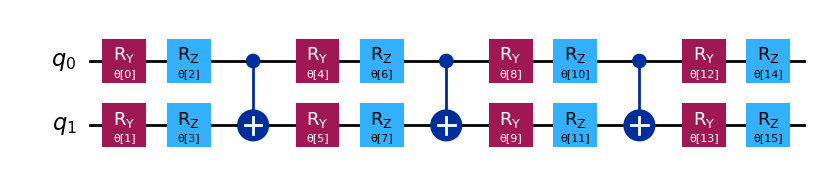

In [3]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

## Preparing for Quantum Execution

To reduce the total job execution time, Qiskit primitives only accept circuits (ansatz) and observables (Hamiltonian) that conform to the instructions and connectivity supported by the target system (referred to as instruction set architecture (ISA) circuits and observables).

ISA circuit Schedule a series of `qiskit.transpiler` passes to optimize the circuit for a selected backend and make it compatible with the backend's ISA. This can be easily done with a preset pass manager from `qiskit.transpiler` and its `optimization_level` parameter.

The lowest optimization level does the minimum needed to get the circuit running on the device; it maps the circuit qubits to the device qubits and adds swap gates to allow all two-qubit operations. The highest optimization level is much smarter and uses lots of tricks to reduce the overall gate count. Since multi-qubit gates have high error rates and qubits decohere over time, the shorter circuits should give better results.

In [4]:
# In principle, this code is not needed unless we intend to run it on a quantum device
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

## ISA observable

Transform the Hamiltonian to make it backend-compatible before running jobs with `Runtime Estimator V2`. Perform the transformation by using the apply_layout method of SparsePauliOp object.

In [5]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

# Variational Quantum Eigensolver

The VQE is the first type of hybrid quantum--classical which was proposed, and it is the first one we will deal with. The cost function in this case based on the Ritz variational principle, that is

\begin{equation}
    C(\boldsymbol{\theta}) = \bra{\psi(\boldsymbol{\theta})}\mathcal{H}\ket{psi(\boldsymbol{\theta})}.
\end{equation}

The minimum of this function is the ground-state energy:

\begin{equation}
    E_0 = \min_{\boldsymbol{\theta}}\bra{\psi(\boldsymbol{\theta})}\mathcal{H}\ket{psi(\boldsymbol{\theta})}.
\end{equation}

We thus have the first component of our VQA, the cost function.

With the Qiskit Runtime `Estimator` directly taking a Hamiltonian and parameterized ansatz, and returning the necessary energy, the cost function for a VQE instance is quite simple.

Note that the `run()` method of Qiskit Runtime `EstimatorV2` takes an iterable of `primitive unified blocs (PUBs)`. Each PUB is an iterable in the format `(circuit, observables, parameter_values: Optional, precision: Optional)`.


In [6]:
def cost_function(params, ansatz, hamiltonian, estimator):
	pub = (ansatz, [hamiltonian], [params])
	result = estimator.run(pubs=[pub]).result()
	energy = result[0].data.evs[0]
	
	cost_history_dict["iters"] += 1
	cost_history_dict["prev_vector"] = params
	cost_history_dict["cost_history"].append(energy)
	print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")
	
	return energy

## Classical optimizer

As we said, for now shall focus on statevector simulations and not worry about measurements. The next step is then choose a classical optimizer. Qiskit has many optimizers to choose from. Quite a bit of them are based on Scipy's implementations. We will take the COBYLA optimizer for the time being.

In [7]:
optimizer = COBYLA()

## Putting it all together

We now just need to run the algorithm optimizing through to get our ground-state energy

In [8]:
x0 = np.random.uniform(-np.pi, np.pi, len(ansatz.parameters))  # We need an initial point (which can be random)

with Session(backend=backend) as session:
	estimator = Estimator(mode=session)
	estimator.options.default_shots = 10000
		
	wrapped_cost_fuction = partial(cost_function, ansatz=ansatz_isa, hamiltonian=hamiltonian_isa, estimator=estimator)
	result = optimizer.minimize(fun=wrapped_cost_fuction, x0=x0)

print(result)

Iters. done: 1 [Current cost: 0.17727334000000006]
Iters. done: 2 [Current cost: 0.09491160000000003]
Iters. done: 3 [Current cost: 0.11445962]
Iters. done: 4 [Current cost: 0.31947454000000003]
Iters. done: 5 [Current cost: 0.11564458]
Iters. done: 6 [Current cost: 0.25708338000000003]
Iters. done: 7 [Current cost: -0.29484]
Iters. done: 8 [Current cost: -0.011804079999999967]
Iters. done: 9 [Current cost: -0.50751918]
Iters. done: 10 [Current cost: -0.33783917999999996]
Iters. done: 11 [Current cost: -0.26545]
Iters. done: 12 [Current cost: -0.31309904000000005]
Iters. done: 13 [Current cost: -0.19387833999999998]
Iters. done: 14 [Current cost: -0.32750266000000006]
Iters. done: 15 [Current cost: -0.10299307999999999]
Iters. done: 16 [Current cost: -0.37012988]
Iters. done: 17 [Current cost: -0.41050380000000003]
Iters. done: 18 [Current cost: -0.45347203999999997]
Iters. done: 19 [Current cost: -0.47639070000000006]
Iters. done: 20 [Current cost: -0.4920217800000001]
Iters. done: 21

## Understanding the Results

The above result shows us:
- `fun`: the final optimised cost.
- `nfev`: the amount of function evaluations, i.e. evaluations of the  cost function.
- `jac`: if a jacobian function was used (in this case we did not use one, and we used finite differences to evaluate the gradient).
- `nit`: the number of iterations, i.e. the number of times the minimum was updated.
- `njev`: the number of times the gradient was evaluated.
- `x`: the final optimized parameters for our PQC.

Let us now plot some results.

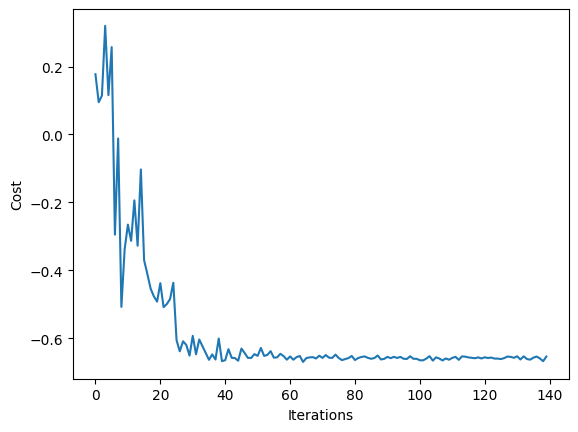

In [9]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

## Looking at the Plot

We can see the cost decreasing as the number of iterations increase. Now how do we confirm that we have achieved the minimum?

For small problems we can compute the minimum by diagonalizing the Hamiltonian.

-0.702930394459531


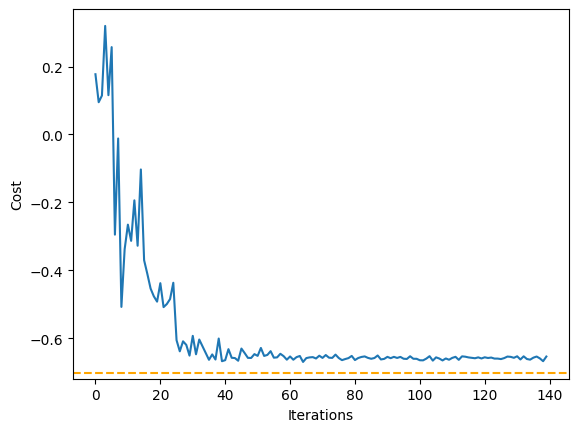

In [10]:
# Getting eigenvalues and eigenvectors from the hamiltonian
u, v = np.linalg.eigh(hamiltonian)

# Printing lowest eigenvalue
print(min(u))

# Updating plot
ax.axhline(y = min(u), color='orange', linestyle = '--')
fig

# We can now see that the minimum is achieved!





## Trying Different Optimizers

Now try to experiment with changing the optimizer: you can find a list of them supported by `Qiskit` [here](https://qiskit-community.github.io/qiskit-algorithms/apidocs/qiskit_algorithms.optimizers.html).

Gradient-based:
- `L_BFGS_B`': second-order gradient descent method.
- `SPSA`: a stochastic gradient descent method.

Gradient-free:
- `NELDER_MEAD`: simplex method.
- `POWELL`: conjugate direction method.

In [11]:
# optimizer = <OPTIMIZER>()
# 
# with Session(backend=backend) as session:
# 	estimator = Estimator(mode=session)
# 	estimator.options.default_shots = 10000
# 	
# 	wrapped_cost_fuction = partial(cost_function, ansatz=ansatz_isa, hamiltonian=hamiltonian_isa, estimator=estimator)
# 	result = optimizer.minimize(fun=wrapped_cost_fuction, x0=x0)
# 
# print(result)
# 
# fig, ax = plt.subplots()
# ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
# ax.axhline(y = min(u), color='orange', linestyle = '--')
# ax.set_xlabel("Iterations")
# ax.set_ylabel("Cost")
# plt.draw()